In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from yahoo_fin.stock_info import get_data

In [2]:
# Extracting data from csv files to DataFrame

def extract_first_non_nan(lst):              # Custom function to extract the first non-NaN value from a list or single value
    if isinstance(lst, list):
        for item in lst:
            if not pd.isna(item):
                return item
    else:  # Handle single values
        if not pd.isna(lst):
            return lst
    return np.nan

dfs = []

directory = r'C:\Users\Rushi\Desktop\Finance_Project_course\Market_terms'   # add path to the CSV file
os.chdir(directory)                        # Change the current working directory to the directory containing the CSV files

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'): 
        df = pd.read_csv(filename, skiprows=15)                # Read the CSV file and skip the first 15 rows
        df['Year'] = pd.to_datetime(df['date'], format='%d-%m-%Y').dt.year
        dfs.append(df)


combined_df = pd.concat(dfs, ignore_index=True)

# Group by year and apply the custom function to each cell
final_df = combined_df.groupby('Year').agg(lambda x: extract_first_non_nan(x.tolist())).reset_index()

years_df = pd.DataFrame({'Year': range(2000, 2024)})
final_df = pd.merge(years_df, final_df, on='Year', how='left')

# Rename few columns
final_df = final_df.rename(columns={' value': 'National Growth by year'})

# Drop the columns
final_df.drop(columns=['date','N','Unnamed: 2', ' '], inplace=True)
final_df = final_df.fillna(final_df.median())            # Filling the NaN values with the median to retain the sanity of values
final_df.head()


,Year,Truck Sales,Capacity utilization rate,Durable goods order,Housing starts,Industrial Production Index,Retail sales,Health Care Per Capita (US $),Manufacturing output (Billions of US $),U.S. National Unemployment Rate
0,2000,18.114,82.053,367884.72,1636.0,91.626,158325.0,4532.7676,1549.438477,4.0
1,2001,17.251,79.210,311795.62,1600.0,92.030,158789.0,4879.9292,1472.931546,4.2
2,2002,16.220,73.986,284347.08,1698.0,88.545,159543.0,5303.1538,1470.280193,5.7
3,2003,16.426,75.915,288479.82,1853.0,91.240,161691.0,5706.8296,1525.598451,5.8
4,2004,16.304,77.139,297528.84,1911.0,92.407,165998.0,6045.9380,1609.515155,5.7


In [3]:
# Initializing the ticker

tickers = [
    'AAPL', 'AEP', 'PLD', 'CVX', 'GS', 'MMM', 'NKE', 'RIO', 'T', 'UNH', 'WMT'       # input the ticker symbol
]
date_list = final_df['Year'].tolist()
yearly_diff_data_list = []

In [4]:
# Getting stock data, yearly average 
for year in date_list:
    
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    yearly_diff_data = {'Year': year}        # Initialize a dictionary to store the differences for each ticker
    
    for ticker in tickers:
        data = yf.Ticker(ticker).history(start=start_date, end=end_date)
        
        # Calculate the difference between the highest and lowest prices for the current ticker
        yearly_high = data['High'].max()
        yearly_low = data['Low'].min()
        yearly_diff_data[ticker] = (yearly_high + yearly_low)/2
    
    yearly_diff_data_list.append(yearly_diff_data)

# Convert the list of dictionaries to a DataFrame
yearly_diff_df = pd.DataFrame(yearly_diff_data_list)
yearly_diff_df.head()


,Year,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
0,2000,0.671327,13.627709,9.263938,17.101937,73.437897,19.113613,4.007995,5.168020,6.920252,8.707182,11.974102
1,2001,0.314130,16.992685,10.833449,18.853717,66.541999,20.714680,4.628159,4.959992,6.741347,12.399300,11.009746
2,2002,0.298804,12.752308,12.763808,17.318590,56.857416,23.076984,5.022414,5.375450,4.684612,16.987726,11.791561
3,2003,0.285198,10.935412,14.655836,17.112953,59.783088,29.706284,5.437088,6.980595,4.071782,19.615676,11.731793
4,2004,0.685972,14.781012,18.079360,23.382474,72.618497,34.162414,7.827561,8.086417,4.549952,28.927564,12.472003


In [5]:
# Making a ridge Linear regression model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Lists to store performance metrics
tickers = []
train_rmse_list = []
test_rmse_list = []
train_r2_list = []
test_r2_list = []

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

for ticker in yearly_diff_df.columns[1:]:  # Exclude the 'Year' column
    X = final_df.drop(columns=['Year'])    # Assuming Year is not a feature
    y = yearly_diff_df[[ticker]]           # Select the column corresponding to the current ticker
    
    # Transforming features and appling appropiate signs
    X_scaled = scaler.fit_transform(X)
    original_signs = np.sign(X.values)
    
    for i in range(X.shape[0]):  # Iterate through rows
        for j in range(X.shape[1]):  # Iterate through columns
            if original_signs[i, j] == -1:  # Check if original value was negative
                X_scaled[i, j] *= -1  # Apply negative sign to corresponding scaled feature
    
    y_scaled = scaler.fit_transform(y)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=86)
    
    model = Ridge(alpha=1)  
    model.fit(X_train, y_train)
    
    # Evaluate the model's performance
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_rmse = root_mean_squared_error(y_train, train_predictions)
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    tickers.append(ticker)
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

# DataFrame to display performance metrics
performance_df = pd.DataFrame({
    'Ticker': tickers,
    'Train RMSE': train_rmse_list,
    'Test RMSE': test_rmse_list,
    'Train R-squared': train_r2_list,
    'Test R-squared': test_r2_list
})
performance_df



,Ticker,Train RMSE,Test RMSE,Train R-squared,Test R-squared
0,AAPL,0.130812,0.385222,0.695356,0.148482
1,AEP,0.093669,0.272614,0.895746,0.372791
2,PLD,0.107011,0.321567,0.798025,0.261265
3,CVX,0.056203,0.349607,0.919472,-0.099645
4,GS,0.110213,0.320940,0.772492,0.186850
5,MMM,0.123951,0.093165,0.875413,0.830884
6,NKE,0.124718,0.219337,0.794156,0.446314
7,RIO,0.107452,0.304437,0.794151,0.251505
8,T,0.120132,0.180719,0.884298,0.688585
9,UNH,0.094157,0.376901,0.828740,0.149887


In [6]:
# Sanity check, for tranform X data, not important for the model (optional)
 
inverse_transformed_columns = []
for i, (col_name, col) in enumerate(X.items()):
    if original_signs[:, i].any() == -1:
        inverse_transformed_column = scaler.inverse_transform(X_scaled[:, i].reshape(-1, 1))
        inverse_transformed_columns.append(pd.Series(inverse_transformed_column.flatten(), name=col_name))
    else:
        inverse_transformed_columns.append(col)
X_inverse_df = pd.concat(inverse_transformed_columns, axis=1)

X_inverse_df.head()

,Truck Sales,Capacity utilization rate,Durable goods order,Housing starts,Industrial Production Index,Retail sales,Health Care Per Capita (US $),Manufacturing output (Billions of US $),U.S. National Unemployment Rate
0,18.114,82.053,367884.72,1636.0,91.626,158325.0,4532.7676,1549.438477,4.0
1,17.251,79.210,311795.62,1600.0,92.030,158789.0,4879.9292,1472.931546,4.2
2,16.220,73.986,284347.08,1698.0,88.545,159543.0,5303.1538,1470.280193,5.7
3,16.426,75.915,288479.82,1853.0,91.240,161691.0,5706.8296,1525.598451,5.8
4,16.304,77.139,297528.84,1911.0,92.407,165998.0,6045.9380,1609.515155,5.7


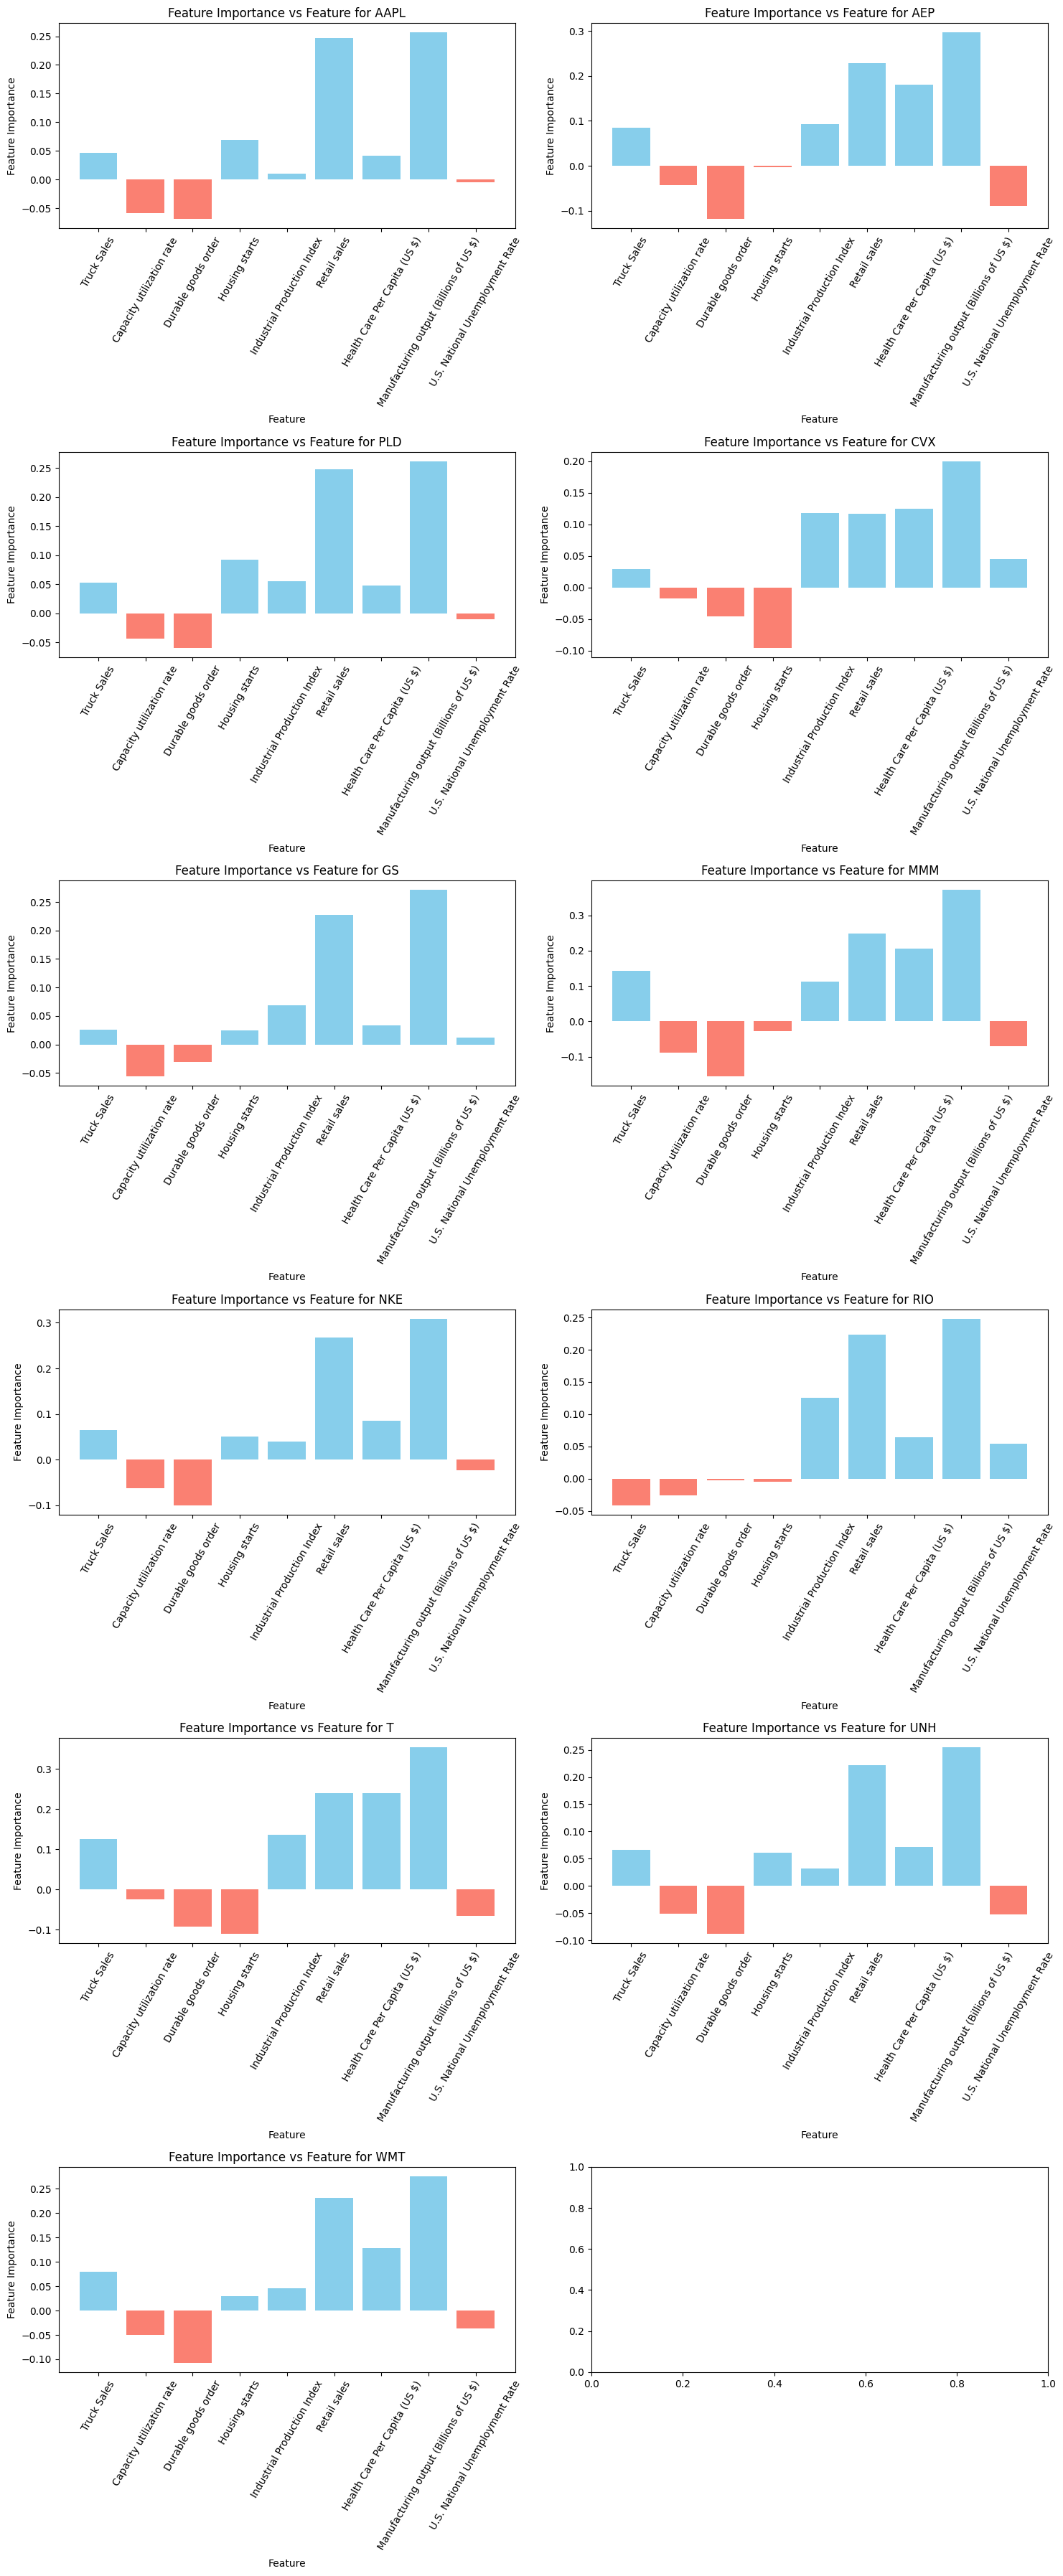

In [7]:
# Ploting the feature importance for all ticker

scaler = MinMaxScaler(feature_range=(0, 1))
feature_importance_dfs = {}
tickers = yearly_diff_df.columns[1:]  # Exclude the 'Year' column
num_plots = len(tickers)
num_rows = (num_plots + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 6 * num_rows))

for i, ticker in enumerate(tickers):
    ax = axes[i // 2, i % 2]  # Select subplot
    X = final_df.drop(columns=['Year'])  # Assuming Year is not a feature
    y = yearly_diff_df[[ticker]]  # Select the column corresponding to the current ticker
    
    # Fit and transform features
    X_scaled = scaler.fit_transform(X)
    original_signs = np.sign(X.values)
    
    for i in range(X.shape[0]):  # Iterate through rows
        for j in range(X.shape[1]):  # Iterate through columns
            if original_signs[i, j] == -1:  # Check if original value was negative
                X_scaled[i, j] *= -1  # Apply negative sign to corresponding scaled feature

    y_scaled = scaler.fit_transform(y)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=86)
    
    # Train a Ridge regression model with regularization
    model = Ridge(alpha=1)  
    model.fit(X_train, y_train)
    
    # Retrieve feature importance
    feature_importance = model.coef_[0]
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    })

    feature_importance_dfs[ticker] = feature_importance_df
    
    # Plot feature importance vs feature
    ax.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], 
           color=['skyblue' if imp >= 0 else 'salmon' for imp in feature_importance_df['Importance']])
    ax.set_xlabel('Feature')
    ax.set_ylabel('Feature Importance')
    ax.set_title(f'Feature Importance vs Feature for {ticker}')
    ax.tick_params(axis='x', rotation=60)

# Adjust layout
plt.tight_layout()
plt.show()


In [8]:
# Displaying feature importance

feature_importance_df = pd.DataFrame(columns=feature_importance_dfs[tickers[0]]['Feature'])
feature_importance_df.index.name = 'Ticker'

for ticker, df in feature_importance_dfs.items():
    feature_importance_df.loc[ticker] = df.set_index('Feature')['Importance']

feature_importance_df.head() # this is features vs ticker dataframe

Feature,Truck Sales,Capacity utilization rate,Durable goods order,Housing starts,Industrial Production Index,Retail sales,Health Care Per Capita (US $),Manufacturing output (Billions of US $),U.S. National Unemployment Rate
Ticker,,,,,,,,,
AAPL,0.047016,-0.058434,-0.069249,0.069132,0.009550,0.246629,0.041208,0.256482,-0.004415
AEP,0.084454,-0.042724,-0.118549,-0.002379,0.093422,0.228213,0.179614,0.296314,-0.089069
PLD,0.053539,-0.043038,-0.059217,0.092561,0.056005,0.248388,0.047838,0.261684,-0.010310
CVX,0.029091,-0.017814,-0.045994,-0.095584,0.117676,0.117182,0.125284,0.199980,0.045208
GS,0.025816,-0.056220,-0.030513,0.024270,0.069175,0.227650,0.034130,0.270975,0.012651


In [9]:
# Making Year vs features dataframe
factors_df = final_df.copy()
factors_df.reset_index(drop=True, inplace=True)
factors_df = factors_df.transpose()
factors_df.columns = factors_df.iloc[0]  # Set the first row as column names
factors_df = factors_df[1:]  # Exclude the first row (previously used as column names)
#factors_df.head()

In [10]:
# scaling down the features as the model is trained on scaled downed feature
factors_df_transposed = factors_df.transpose()
scaler = MinMaxScaler(feature_range=(0,1))
factors_df_scaled = pd.DataFrame(scaler.fit_transform(factors_df_transposed), columns=factors_df_transposed.columns, index=factors_df_transposed.index)
factors_df_scaled.head()  # this is features vs Year dataframe

,Truck Sales,Capacity utilization rate,Durable goods order,Housing starts,Industrial Production Index,Retail sales,Health Care Per Capita (US $),Manufacturing output (Billions of US $),U.S. National Unemployment Rate
Year,,,,,,,,,
2000.0,1.000000,1.000000,1.000000,0.642737,0.213378,0.000000,0.000000,0.077088,0.093750
2001.0,0.898958,0.767767,0.618829,0.622546,0.240676,0.006328,0.048421,0.002582,0.125000
2002.0,0.778246,0.341039,0.432294,0.677510,0.005203,0.016611,0.107451,0.000000,0.359375
2003.0,0.802365,0.498611,0.460380,0.764442,0.187297,0.045905,0.163755,0.053872,0.375000
2004.0,0.788081,0.598595,0.521875,0.796971,0.266149,0.104644,0.211052,0.135594,0.359375


In [11]:
factors_df_scaled = factors_df_scaled.transpose()  # Year vs features dataframe

In [12]:
# Matrix multiplication
predicted_data = feature_importance_df.dot(factors_df_scaled)
predicted_data =predicted_data.transpose()
predicted_data.head()   # to get ticker vs year dataframe

Ticker,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000.0,-0.014838,-0.043922,0.041933,-0.051388,-0.008482,-0.075126,-0.034670,-0.022216,-0.014291,-0.012913,-0.032383
2001.0,0.003551,-0.009467,0.052819,-0.034196,-0.001707,-0.024120,-0.006410,-0.019815,0.004939,0.010025,-0.001131
2002.0,0.040551,-0.010137,0.069954,-0.035810,0.016526,-0.005034,0.025731,-0.014991,-0.020042,0.029997,0.022136
2003.0,0.061574,0.030013,0.104951,-0.004122,0.045525,0.035712,0.055362,0.026612,0.030071,0.055583,0.052264
2004.0,0.091269,0.072041,0.142068,0.025468,0.080836,0.078933,0.092278,0.069764,0.082517,0.086620,0.086790


In [13]:
# actual data
yearly_diff_df.set_index("Year", inplace=True)
yearly_diff_df.head()

,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000,0.671327,13.627709,9.263938,17.101937,73.437897,19.113613,4.007995,5.168020,6.920252,8.707182,11.974102
2001,0.314130,16.992685,10.833449,18.853717,66.541999,20.714680,4.628159,4.959992,6.741347,12.399300,11.009746
2002,0.298804,12.752308,12.763808,17.318590,56.857416,23.076984,5.022414,5.375450,4.684612,16.987726,11.791561
2003,0.285198,10.935412,14.655836,17.112953,59.783088,29.706284,5.437088,6.980595,4.071782,19.615676,11.731793
2004,0.685972,14.781012,18.079360,23.382474,72.618497,34.162414,7.827561,8.086417,4.549952,28.927564,12.472003


In [14]:
# Scaling down the yearly_diff_df(actual scaled down data)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(yearly_diff_df)
yearly_diff_scaled = pd.DataFrame(scaled_data, columns=yearly_diff_df.columns, index = yearly_diff_df.index)
yearly_diff_scaled.head()


,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000,0.002397,0.035175,0.000000,0.000000,0.059610,0.000000,0.000000,0.003534,0.210252,0.000000,0.029904
2001,0.000180,0.079139,0.013045,0.012367,0.034818,0.013458,0.004316,0.000000,0.197047,0.007581,0.005551
2002,0.000084,0.023738,0.029090,0.001529,0.000000,0.033314,0.007059,0.007058,0.045234,0.017003,0.025294
2003,0.000000,0.000000,0.044816,0.000078,0.010518,0.089036,0.009945,0.034326,0.000000,0.022399,0.023785
2004,0.002488,0.050243,0.073271,0.044338,0.056664,0.126491,0.026580,0.053112,0.035295,0.041520,0.042478


In [15]:
# Writing the inverse function for actual to scale up the actual scaled down data
actual_data = scaler.inverse_transform(yearly_diff_scaled)
actual_df = pd.DataFrame(actual_data, columns=yearly_diff_scaled.columns, index=yearly_diff_scaled.index)
actual_df.head()

,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000,0.671327,13.627709,9.263938,17.101937,73.437897,19.113613,4.007995,5.168020,6.920252,8.707182,11.974102
2001,0.314130,16.992685,10.833449,18.853717,66.541999,20.714680,4.628159,4.959992,6.741347,12.399300,11.009746
2002,0.298804,12.752308,12.763808,17.318590,56.857416,23.076984,5.022414,5.375450,4.684612,16.987726,11.791561
2003,0.285198,10.935412,14.655836,17.112953,59.783088,29.706284,5.437088,6.980595,4.071782,19.615676,11.731793
2004,0.685972,14.781012,18.079360,23.382474,72.618497,34.162414,7.827561,8.086417,4.549952,28.927564,12.472003


In [16]:
# Using the inverse function on the predicted data to scale up
original_predicted_data = scaler.inverse_transform(predicted_data)
original_predicted_df = pd.DataFrame(original_predicted_data, columns=predicted_data.columns, index=predicted_data.index)
original_predicted_df.head()

Ticker,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000.0,-2.104517,7.573647,14.309029,9.822804,54.498070,10.175802,-0.974174,3.652265,3.878168,2.418628,9.507660
2001.0,0.857151,10.210798,15.618701,12.258069,56.382740,16.243989,3.086911,3.793575,4.138700,13.589288,10.745155
2002.0,6.816310,10.159540,17.680199,12.029465,61.454113,18.514669,7.705664,4.077560,3.800262,23.315889,11.666500
2003.0,10.202303,13.232563,21.890808,16.518097,69.520232,23.362338,11.963717,6.526488,4.479176,35.776604,12.859489
2004.0,14.984820,16.449371,26.356397,20.709505,79.341955,28.504397,17.268552,9.066648,5.189715,50.891723,14.226652


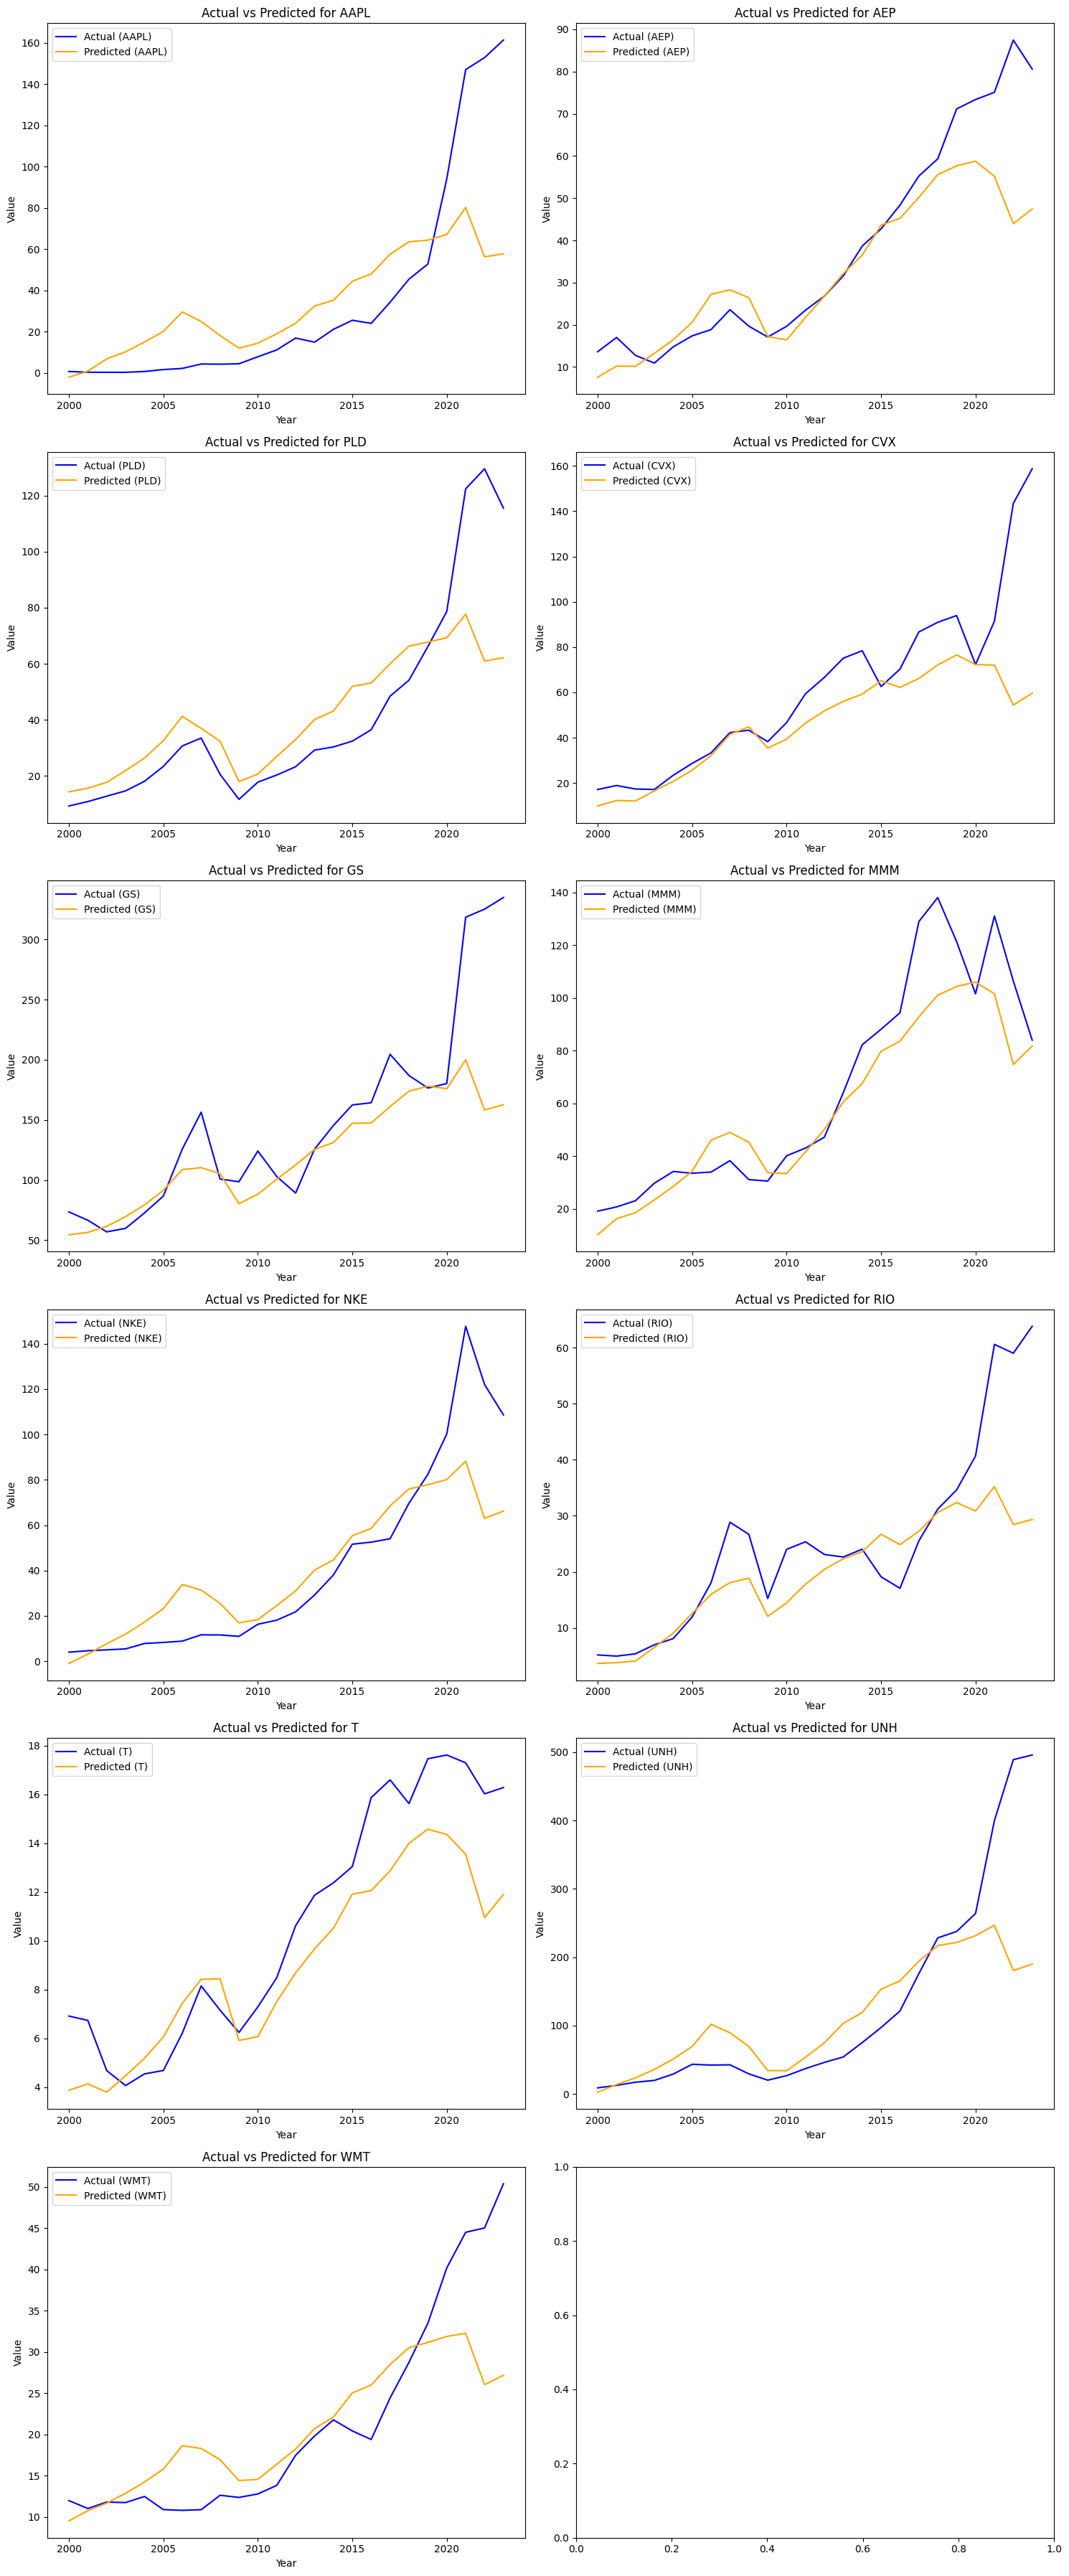

In [17]:
# Plotting actual vs predicted

num_tickers = len(actual_df.columns)
num_rows = (num_tickers + 1) // 2  
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))
axes = axes.flatten()


for i, (ticker, ax) in enumerate(zip(actual_df.columns, axes)):
    ax.plot(actual_df.index, actual_df[ticker], label=f'Actual ({ticker})', color='blue')
    ax.plot(original_predicted_df.index, original_predicted_df[ticker], label=f'Predicted ({ticker})', color='orange')
    
    ax.set_title(f'Actual vs Predicted for {ticker}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()
